# Industrial Meter Reader

This notebook shows how an industrial energy meter reader solution can be deployed with OpenVINO™
Toolkit. This solution can be used to translate readings from pointer meters to digital readings
using computer vision.

### The models used in this notebook are pre-trained PaddlePaddle models:

- [PP-YOLOv2](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/ppyolo)
- [DeepLabV3P](https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.5/configs/deeplabv3p)

## Prerequisites

This tutorial requires the following:

- All files are present and in the following directory structure:
  - **meter-reader.ipynb** - This Jupyter Notebook
  - **notebook_utils.py**
  - **async_pipeline.py**
- Optional: URL to user's image or video to run inference on

## Inference pipeline work flow

The inference pipeline in this notebook takes input in the form of industrial meters images then
produces output in the form of numerical values of the meters readings. The following tasks are run
in the inference pipeline:

```
1) Run detection model to find the meters and crop the detected meters from the source image.
2) Run segmentation model on the meters to get the pointer and scale instance.
3) Find the location of the pointer in scale map.
4) Return the results.
```

![workflow](https://user-images.githubusercontent.com/91237924/166137115-67284fa5-f703-4468-98f4-c43d2c584763.png)

## Sample Application

The following sections will guide you through a sample application:

## Import

Begin by importing all of the Python modules that will be used by the sample code:

- [os](https://docs.python.org/3/library/os.html#module-os) - Operating system specific module (used
  for file name parsing).
- [sys](https://docs.python.org/3/library/sys.html) - Allows access to system variables used or
  maintained by the python console interpreter.
- [path](https://docs.python.org/3/library/pathlib.html#pathlib.Path) - Represents concrete paths of
  the system’s path.
- [numpy](https://numpy.org/doc/stable/user/whatisnumpy.html) - NumPy is the fundamental package for
  scientific computing in Python.
- [math](https://docs.python.org/3/library/math.html) - Provides access to the mathematical
  functions defined by the C standard.
- [cv2](https://docs.opencv.org/trunk/) - OpenCV module.
- [tarfile](https://docs.python.org/3/library/tarfile.html) - Used to read and write tar archives.
- [matplotlib](https://matplotlib.org/) - Pyplot is used for displaying output images.
- [openvino.runtime](https://docs.openvino.ai/latest/openvino_docs_OV_UG_OV_Runtime_User_Guide.html)
  \- Set of C++ libraries with C and Python bindings providing a common API to deliver inference
  solutions on the platform of your choice. Will be used to deploy the PaddlePaddle model of the
  Energy Meter Model.

Run the cell below to import Python dependencies needed for displaying the results in this notebook.
<br><div class=tip><b>Tip: </b>Select a cell and then use **Ctrl+Enter** to run that cell.</div>

In [1]:
import math
import os
import sys
import tarfile
from pathlib import Path

import cv2
import matplotlib.pyplot as plt
import numpy as np
from openvino.runtime import Core

from notebook_utils import download_file, segmentation_map_to_image

print("Imported Python modules successfully.")

Imported Python modules successfully.


## Prepare models and test images

1. Setup folder structure.
2. Download the pre-trained models:
   - Detection:
     [PP-YOLOv2](https://github.com/PaddlePaddle/PaddleDetection/tree/release/2.4/configs/ppyolo)
   - Segmentation:
     [DeepLabV3P](https://github.com/PaddlePaddle/PaddleSeg/tree/release/2.5/configs/deeplabv3p)
3. Download sample input image:
   - URL:
     "https://user-images.githubusercontent.com/91237924/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg"

In [ ]:
MODEL_DIR = "model"
DATA_DIR = "data"
DET_MODEL_LINK = (
    "https://bj.bcebos.com/paddlex/examples2/meter_reader/meter_det_model.tar.gz"
)
SEG_MODEL_LINK = (
    "https://bj.bcebos.com/paddlex/examples2/meter_reader/meter_seg_model.tar.gz"
)
DET_FILE_NAME = DET_MODEL_LINK.split("/")[-1]
SEG_FILE_NAME = SEG_MODEL_LINK.split("/")[-1]
IMG_LINK = "https://user-images.githubusercontent.com/91237924/170696219-f68699c6-1e82-46bf-aaed-8e2fc3fa5f7b.jpg"
IMG_FILE_NAME = IMG_LINK.split("/")[-1]
IMG_PATH = Path(f"{DATA_DIR}/{IMG_FILE_NAME}")

os.makedirs(MODEL_DIR, exist_ok=True)

download_file(DET_MODEL_LINK, directory=MODEL_DIR, show_progress=True)
file = tarfile.open(f"model/{DET_FILE_NAME}")
res = file.extractall("model")
if not res:
    print(f'Detection Model Extracted to "./{MODEL_DIR}".')
else:
    print("Error Extracting the Detection model. Please check the network.")

download_file(SEG_MODEL_LINK, directory=MODEL_DIR, show_progress=True)
file = tarfile.open(f"model/{SEG_FILE_NAME}")
res = file.extractall("model")
if not res:
    print(f'Segmentation Model Extracted to "./{MODEL_DIR}".')
else:
    print("Error Extracting the Segmentation model. Please check the network.")

download_file(IMG_LINK, directory=DATA_DIR, show_progress=True)
if IMG_PATH.is_file():
    print(f'Test Image Saved to "./{DATA_DIR}".')
else:
    print("Error Downloading the Test Image. Please check the network.")

## Configuration

Add parameter configuration for reading calculation.

In [ ]:
METER_SHAPE = [512, 512]
CIRCLE_CENTER = [256, 256]
CIRCLE_RADIUS = 250
PI = math.pi
RECTANGLE_HEIGHT = 120
RECTANGLE_WIDTH = 1570
TYPE_THRESHOLD = 40
COLORMAP = np.array([[28, 28, 28], [238, 44, 44], [250, 250, 250]])

# There are 2 types of meters in test image datasets
METER_CONFIG = [
    {"scale_interval_value": 25.0 / 50.0, "range": 25.0, "unit": "(MPa)"},
    {"scale_interval_value": 1.6 / 32.0, "range": 1.6, "unit": "(MPa)"},
]

SEG_LABEL = {"background": 0, "pointer": 1, "scale": 2}

## Load the Models

In this section:

1. We load and initialize the PaddlePaddle detection and segmentation models
2. Specify the compute device_name

**Note:** since we're using a PaddlePaddle model, the model can be loaded directly to OpenVINO
runtime without having to convert the model to IR format.

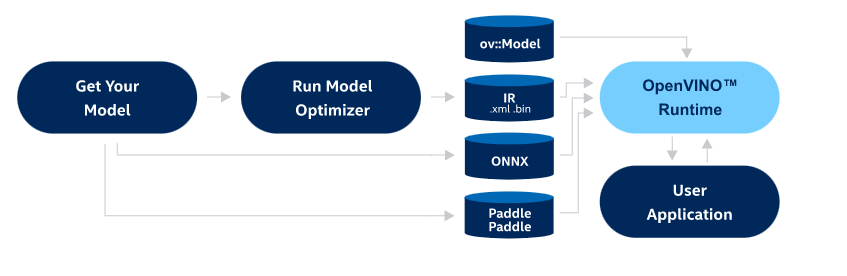

In [ ]:
# Initialize OpenVINO Runtime
ie_core = Core()


def model_init(det_model_path, seg_model_path):
    """
    Initialize the Detection and Segmentation models

    :param:
            model (str): model path *.pdmodel
    :returns:
            detector: detection compiled model
            segmenter: segmentation compiled model

    """

    # Load the PaddlePaddle detection model directly
    det_model = ie_core.read_model(model=det_model_path)
    det_model.reshape(
        {"image": [1, 3, 608, 608], "im_shape": [1, 2], "scale_factor": [1, 2]}
    )
    detector = ie_core.compile_model(model=det_model, device_name="CPU")

    # Load the PaddlePaddle segmentation model directly, the input batch size is dynamic
    seg_model = ie_core.read_model(model=seg_model_path)
    seg_model.reshape({"image": [-1, 3, 512, 512]})
    segmenter = ie_core.compile_model(model=seg_model, device_name="CPU")

    return detector, segmenter

## Predictor

Define a common predictor function that returns results of the inference pipeline.

In [ ]:
def predictor(input, compiled_model):
    """
    A predictor to run inference

    :param:
            input: input data
            compiled_model: an IE detector or segmenter
    :returns:
            result (np.array): model output data

    """
    output_layer = compiled_model.output(0)
    result = compiled_model(input)[output_layer]
    return result

## Data Process

Define pre-processing and post-processing functions for the detection and segmentation models.

In [ ]:
def det_preprocess(input_image, target_size):
    """
    Pre-processing the input data for detection task

    :param:
            input_image (np.array): input data
            size (int): the image size required by model input layer
    :returns:
            img.astype (np.float32): preprocessed image

    """
    img = cv2.resize(input_image, (target_size, target_size))
    img = np.transpose(img, [2, 0, 1]) / 255
    img = np.expand_dims(img, 0)
    img_mean = np.array([0.485, 0.456, 0.406]).reshape((3, 1, 1))
    img_std = np.array([0.229, 0.224, 0.225]).reshape((3, 1, 1))
    img -= img_mean
    img /= img_std
    return img.astype(np.float32)


def filter_bboxes(det_results, score_threshold):
    """
    filter out the detection results with low confidence

    :param：
        det_results (list[dict]): detection results
        score_threshold (float)： confidence threshold

    :returns：
        filtered_results (list[dict]): filter detection results

    """
    filtered_results = []
    for i in range(len(det_results)):
        if det_results[i, 1] > score_threshold:
            filtered_results.append(det_results[i])
    return filtered_results


def roi_crop(image, results, scale_x, scale_y):
    """
    crop the area of detected meter of original image

    :param：
        img (np.array)：original image。
        det_results (list[dict]): detection results
        scale_x (float): the scale value in x axis
        scale_y (float): the scale value in y axis

    :returns：
        roi_imgs (list[np.array]): the list of meter images
        loc (list[int]): the list of meter locations

    """
    roi_imgs = []
    loc = []
    for result in results:
        bbox = result[2:]
        xmin, ymin, xmax, ymax = [
            int(bbox[0] * scale_x),
            int(bbox[1] * scale_y),
            int(bbox[2] * scale_x),
            int(bbox[3] * scale_y),
        ]
        sub_img = image[ymin : (ymax + 1), xmin : (xmax + 1), :]
        roi_imgs.append(sub_img)
        loc.append([xmin, ymin, xmax, ymax])
    return roi_imgs, loc


def roi_process(input_images, target_size, interp=cv2.INTER_LINEAR):
    """
    Prepare the roi image of detection results data
    Pre-processing the input data for segmentation task

    :param：
        input_images (list[np.array])：the list of meter images
        target_size (list|tuple)： height and width of resized image， e.g., [heigh,width]
        interp (int)：the interpolation method for image resizing

    :returns：
        img_list (list[np.array])：the list of processed images
        resize_img (list[np.array]): for visualization

    """
    img_list = list()
    resize_list = list()
    for img in input_images:
        img_shape = img.shape
        scale_x = float(target_size[1]) / float(img_shape[1])
        scale_y = float(target_size[0]) / float(img_shape[0])
        resize_img = cv2.resize(
            img, None, None, fx=scale_x, fy=scale_y, interpolation=interp
        )
        resize_list.append(resize_img)
        resize_img = resize_img.transpose(2, 0, 1) / 255
        img_mean = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        img_std = np.array([0.5, 0.5, 0.5]).reshape((3, 1, 1))
        resize_img -= img_mean
        resize_img /= img_std
        img_list.append(resize_img)
    return img_list, resize_list


def erode(seg_results, erode_kernel):
    """
    erode the segmentation result to get the more clear instance of pointer and scale

    :param：
        seg_results (list[dict])：segmentation results
        erode_kernel (int): size of erode_kernel

    :return：
        eroded_results (list[dict])： the lab map of eroded_results
    """
    kernel = np.ones((erode_kernel, erode_kernel), np.uint8)
    eroded_results = seg_results
    for i in range(len(seg_results)):
        eroded_results[i] = cv2.erode(seg_results[i].astype(np.uint8), kernel)
    return eroded_results


def circle_to_rectangle(seg_results):
    """
    switch the shape of label_map from circle to rectangle

    :param：
        seg_results (list[dict])：segmentation results

    :return：
        rectangle_meters (list[np.array])：the rectangle of label map

    """
    rectangle_meters = list()
    for i, seg_result in enumerate(seg_results):
        label_map = seg_result

        # The size of rectangle_meter is determined by RECTANGLE_HEIGHT and RECTANGLE_WIDTH
        rectangle_meter = np.zeros((RECTANGLE_HEIGHT, RECTANGLE_WIDTH), dtype=np.uint8)
        for row in range(RECTANGLE_HEIGHT):
            for col in range(RECTANGLE_WIDTH):
                theta = PI * 2 * (col + 1) / RECTANGLE_WIDTH

                # The radius of meter circle will be mapped to the height of rectangle
                rho = CIRCLE_RADIUS - row - 1
                y = int(CIRCLE_CENTER[0] + rho * math.cos(theta) + 0.5)
                x = int(CIRCLE_CENTER[1] - rho * math.sin(theta) + 0.5)
                rectangle_meter[row, col] = label_map[y, x]
        rectangle_meters.append(rectangle_meter)
    return rectangle_meters


def rectangle_to_line(rectangle_meters):
    """
    switch the dimension of rectangle label map from 2D to 1D

    :param：
        rectangle_meters (list[np.array])：2D rectangle OF label_map。

    :return：
        line_scales (list[np.array])： the list of scales value
        line_pointers (list[np.array])：the list of pointers value

    """
    line_scales = list()
    line_pointers = list()
    for rectangle_meter in rectangle_meters:
        height, width = rectangle_meter.shape[0:2]
        line_scale = np.zeros((width), dtype=np.uint8)
        line_pointer = np.zeros((width), dtype=np.uint8)
        for col in range(width):
            for row in range(height):
                if rectangle_meter[row, col] == SEG_LABEL["pointer"]:
                    line_pointer[col] += 1
                elif rectangle_meter[row, col] == SEG_LABEL["scale"]:
                    line_scale[col] += 1
        line_scales.append(line_scale)
        line_pointers.append(line_pointer)
    return line_scales, line_pointers


def mean_binarization(data_list):
    """
    binarize the data

    :param：
        data_list (list[np.array])：input data

    :return：
        binaried_data_list (list[np.array])：output data。

    """
    batch_size = len(data_list)
    binaried_data_list = data_list
    for i in range(batch_size):
        mean_data = np.mean(data_list[i])
        width = data_list[i].shape[0]
        for col in range(width):
            if data_list[i][col] < mean_data:
                binaried_data_list[i][col] = 0
            else:
                binaried_data_list[i][col] = 1
    return binaried_data_list


def locate_scale(line_scales):
    """
    find out the location of center of each scale

    :param：
        line_scales (list[np.array])：the list of binaried scales value

    :return：
        scale_locations (list[list])：location of each scale

    """
    batch_size = len(line_scales)
    scale_locations = list()
    for i in range(batch_size):
        line_scale = line_scales[i]
        width = line_scale.shape[0]
        find_start = False
        one_scale_start = 0
        one_scale_end = 0
        locations = list()
        for j in range(width - 1):
            if line_scale[j] > 0 and line_scale[j + 1] > 0:
                if not find_start:
                    one_scale_start = j
                    find_start = True
            if find_start:
                if line_scale[j] == 0 and line_scale[j + 1] == 0:
                    one_scale_end = j - 1
                    one_scale_location = (one_scale_start + one_scale_end) / 2
                    locations.append(one_scale_location)
                    one_scale_start = 0
                    one_scale_end = 0
                    find_start = False
        scale_locations.append(locations)
    return scale_locations


def locate_pointer(line_pointers):
    """
    find out the location of center of pointer

    :param：
        line_scales (list[np.array])：the list of binaried pointer value

    :return：
        scale_locations (list[list])：location of pointer

    """
    batch_size = len(line_pointers)
    pointer_locations = list()
    for i in range(batch_size):
        line_pointer = line_pointers[i]
        find_start = False
        pointer_start = 0
        pointer_end = 0
        location = 0
        width = line_pointer.shape[0]
        for j in range(width - 1):
            if line_pointer[j] > 0 and line_pointer[j + 1] > 0:
                if not find_start:
                    pointer_start = j
                    find_start = True
            if find_start:
                if line_pointer[j] == 0 and line_pointer[j + 1] == 0:
                    pointer_end = j - 1
                    location = (pointer_start + pointer_end) / 2
                    find_start = False
                    break
        pointer_locations.append(location)
    return pointer_locations


def get_relative_location(scale_locations, pointer_locations):
    """
    match the location of pointer and scales

    :param：
        scale_locations (list[list])：location of each scale
        pointer_locations (list[list])：location of pointer

    :return：
        pointed_scales (list[dict])： a list of dict with:
                                     'num_scales': total number of scales
                                     'pointed_scale': predicted number of scales

    """
    pointed_scales = list()
    for scale_location, pointer_location in zip(scale_locations, pointer_locations):
        num_scales = len(scale_location)
        pointed_scale = -1
        if num_scales > 0:
            for i in range(num_scales - 1):
                if scale_location[i] <= pointer_location < scale_location[i + 1]:
                    pointed_scale = (
                        i
                        + (pointer_location - scale_location[i])
                        / (scale_location[i + 1] - scale_location[i] + 1e-05)
                        + 1
                    )
        result = {"num_scales": num_scales, "pointed_scale": pointed_scale}
        pointed_scales.append(result)
    return pointed_scales


def calculate_reading(pointed_scales):
    """
    calculate the value of meter according the type of meter

    :param：
        pointed_scales (list[list])：predicted number of scales

    :return：
        readings (list[float])： the list of values read from meter

    """
    readings = list()
    batch_size = len(pointed_scales)
    for i in range(batch_size):
        pointed_scale = pointed_scales[i]
        # find out the type of meter according the total number of scales
        if pointed_scale["num_scales"] > TYPE_THRESHOLD:
            reading = (
                pointed_scale["pointed_scale"] * METER_CONFIG[0]["scale_interval_value"]
            )
        else:
            reading = (
                pointed_scale["pointed_scale"] * METER_CONFIG[1]["scale_interval_value"]
            )
        readings.append(reading)
    return readings

## Main Function

### Initialize the model and parameters

In [ ]:
img_file = f"{DATA_DIR}/{IMG_FILE_NAME}"
det_model_path = f"{MODEL_DIR}/meter_det_model/model.pdmodel"
seg_model_path = f"{MODEL_DIR}/meter_seg_model/model.pdmodel"
erode_kernel = 4
score_threshold = 0.5
seg_batch_size = 2
input_shape = 608
detector, segmenter = model_init(det_model_path, seg_model_path)
image = cv2.imread(img_file)
plt.imshow(image)

### Run meter detection model

Detect the location of the meter and prepare the ROI images for segmentation.

In [ ]:
# Prepare the input data for meter detection model
im_shape = np.array([[input_shape, input_shape]]).astype("float32")
scale_factor = np.array([[1, 2]]).astype("float32")
input_image = det_preprocess(image, input_shape)
inputs_dict = {"image": input_image, "im_shape": im_shape, "scale_factor": scale_factor}

# Run meter detection model
det_results = predictor(inputs_dict, detector)

# Filter out the bounding box with low confidence
filtered_results = filter_bboxes(det_results, score_threshold)

# Prepare the input data for meter segmentation model
scale_x = image.shape[1] / input_shape * 2
scale_y = image.shape[0] / input_shape

# Create the individual photo for each detected meter
roi_imgs, loc = roi_crop(image, filtered_results, scale_x, scale_y)
roi_imgs, resize_imgs = roi_process(roi_imgs, METER_SHAPE)

# Create the photos of detection results
if len(resize_imgs) == 2:
    roi_stack = np.hstack([resize_imgs[0], resize_imgs[1]])
else:
    roi_stack = resize_imgs[0]

if cv2.imwrite(f"{DATA_DIR}/detection_results.jpg", roi_stack):
    print(
        'The detection result image has been saved as "detection_results.jpg" in data'
    )
    plt.imshow(roi_stack)

### Run meter segmentation model

Get the results of segmentation task on detected ROI.

In [ ]:
seg_results = list()
num_imgs = len(roi_imgs)

# Run meter segmentation model on all meters detected
for i in range(0, num_imgs, seg_batch_size):
    batch = roi_imgs[i : min(num_imgs, i + seg_batch_size)]
    seg_result = predictor([batch], segmenter)
    seg_results.extend(seg_result)
results = []
for i in range(len(seg_results)):
    results.append(np.argmax(seg_results[i], axis=0))
seg_results = erode(results, erode_kernel)

# Create the photos of segmentation results
if len(resize_imgs) == 2:
    mask_stack = np.hstack(
        [
            segmentation_map_to_image(seg_results[0], COLORMAP),
            segmentation_map_to_image(seg_results[1], COLORMAP),
        ]
    )
else:
    mask_stack = segmentation_map_to_image(seg_results[0], COLORMAP)

if cv2.imwrite(f"{DATA_DIR}/segmentation_results.jpg", mask_stack):
    print(
        'The segmentation result image has been saved as "segmentation_results.jpg" in data'
    )
    plt.imshow(mask_stack)

### Postprocess the models result and calculate the final readings

Use OpenCV function to find the location of the pointer in scale map.

In [ ]:
# Find the pointer location in scale map and calculate the meter's reading
rectangle_meters = circle_to_rectangle(seg_results)
line_scales, line_pointers = rectangle_to_line(rectangle_meters)
binaried_scales = mean_binarization(line_scales)
binaried_pointers = mean_binarization(line_pointers)
scale_locations = locate_scale(binaried_scales)
pointer_locations = locate_pointer(binaried_pointers)
pointed_scales = get_relative_location(scale_locations, pointer_locations)
meter_readings = calculate_reading(pointed_scales)

# Plot the rectangle meters
if len(rectangle_meters) == 2:
    rectangle_meters_stack = np.hstack(
        [
            segmentation_map_to_image(rectangle_meters[0], COLORMAP),
            segmentation_map_to_image(rectangle_meters[1], COLORMAP),
        ]
    )
else:
    rectangle_meters_stack = segmentation_map_to_image(rectangle_meters[0], COLORMAP)

if cv2.imwrite(f"{DATA_DIR}/rectangle_meters.jpg", rectangle_meters_stack):
    print(
        'The rectangle_meters result image has been saved as "rectangle_meters.jpg" in data'
    )
    plt.imshow(rectangle_meters_stack)

### Get the reading result on the meter picture

In [ ]:
# Create final result photo with meter value
for i in range(len(meter_readings)):
    print(f"Meter {i + 1}: {meter_readings[i]:.3f}")

result_image = image.copy()
for i in range(len(loc)):
    cv2.rectangle(
        result_image, (loc[i][0], loc[i][1]), (loc[i][2], loc[i][3]), (0, 150, 0), 3
    )
    font = cv2.FONT_HERSHEY_SIMPLEX
    cv2.rectangle(
        result_image,
        (loc[i][0], loc[i][1]),
        (loc[i][0] + 100, loc[i][1] + 40),
        (0, 150, 0),
        -1,
    )
    cv2.putText(
        result_image,
        f"#{meter_readings[i]:.3f}",
        (loc[i][0], loc[i][1] + 25),
        font,
        0.8,
        (255, 255, 255),
        2,
        cv2.LINE_AA,
    )
if cv2.imwrite(f"{DATA_DIR}/reading_results.jpg", result_image):
    print('The reading results image has been saved as "reading_results.jpg" in data')
    plt.imshow(result_image)

## Try it with your meter photos!